In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname = "C:\Windows\Fonts\malgun.ttf").get_name()
rc('font', family=font_name)
import seaborn as sns
from scipy.optimize import minimize
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
asset_code = ['005930', '035720', '005490', '068270', '018260', '051900', '096770', '036570', '010130', '021240', '035250']
asset_number = len(asset_code)

In [3]:
stock_listing = fdr.StockListing('KOSPI')
asset_list = []

for code in asset_code :
    asset_list.append(stock_listing[stock_listing['Symbol'] == code])

asset_info = pd.concat(asset_list)

In [4]:
asset_data = []

for code in asset_code :
    asset_close = fdr.DataReader(code,'2017')[['Close']]
    asset_data.append(asset_close)

asset_price = pd.concat(asset_data, axis = 1)
asset_price.columns = asset_info['Name'].values

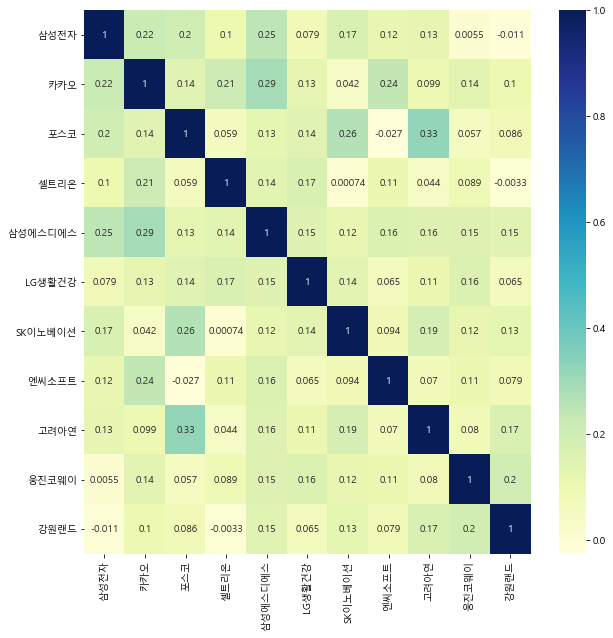

In [5]:
plt.figure(figsize = (10,10))
sns.heatmap(asset_price.pct_change().corr(), cmap='YlGnBu', annot=True) # cmap=mpl.cm.bone_r
plt.show()

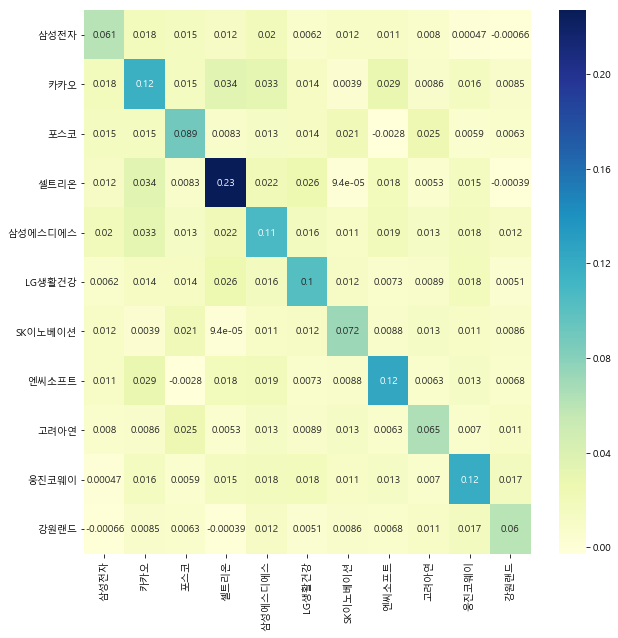

In [5]:
plt.figure(figsize = (10,10))
sns.heatmap(asset_price.pct_change().cov()*252, cmap='YlGnBu', annot=True) # cmap=mpl.cm.bone_r
plt.show()

In [6]:
data = asset_price.pct_change()

In [7]:
expected_return = np.array(data.mean()*252)
covariance_martix = data.cov()*252

In [8]:
def objective(weights):
    return np.sqrt(np.dot(weights.T, np.dot(covariance_martix, weights)))

def constraint1(weights):
    return sum(weights)-1

w0 = np.array([(1/asset_number) for i in range(asset_number)])
bounds = [[0,1] for i in range(asset_number)]
constraints = [{'type':'eq','fun':constraint1}]

solution = minimize(objective,w0,method='SLSQP', bounds = bounds, constraints = constraints)

In [9]:
print("Global Minimum Variance :", np.array(solution.fun).round(3))
print("Expected Return :", (expected_return*solution.x).sum().round(3))

Global Minimum Variance : 0.132
Expected Return : 0.087


In [10]:
def min_std(weight) :
    return np.sqrt(np.dot(weight.T, np.dot(covariance_martix, weight)))

basic_var = np.array([(1/asset_number) for i in range(asset_number)])
bnds = [[0,1] for i in range(asset_number)]
cons = [{'type':'eq','fun':constraint1}]

ef_return = np.linspace((expected_return*solution.x).sum(), 0.35, 100)
ef_std = []
ef_weights = []

for r in ef_return :
    con1 = {'type':'eq','fun': lambda x : np.sum(x) - 1}
    con2 = {'type':'eq','fun': lambda x : (expected_return*x).sum() - r}
    cons = [con1,con2]
    solution_min_std = minimize(min_std, basic_var, method = 'SLSQP', bounds = bnds, constraints = cons)
    
    ef_weights.append([np.array(r).round(3), solution_min_std.x.round(3)])
    ef_std.append(solution_min_std.fun)
    
ef_std = np.array(ef_std)

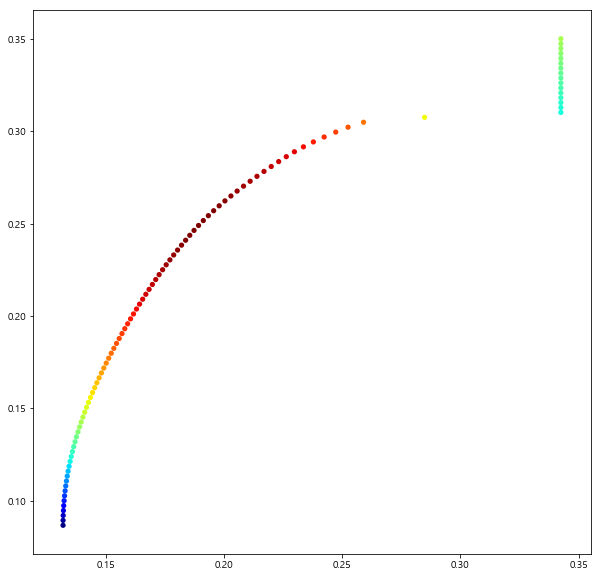

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(ef_std, ef_return, c = ef_return/ef_std, s=5, linewidth=3, cmap=mpl.cm.jet)